# Analysis for the the one with curriculum learning

In [1]:
import tbparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# For the training

In [2]:
from tbparse import SummaryReader
Gen_ARL_train = r"../../TrainerConfig/results/NoCurr42d/Generator/"
Solver_ARL_train = r"../../TrainerConfig/results/NoCurr42d/Solver/"
reader_gen = SummaryReader(Gen_ARL_train)
reader_solver = SummaryReader(Solver_ARL_train)
df_solver = reader_solver.scalars
df_gen = reader_gen.scalars
pd.unique(df_gen["tag"])
# df_gen.head()
# df_gen

array(['Environment/Cumulative Reward', 'Environment/Episode Length',
       'Environment/Lesson Number/aux_input',
       'Environment/Lesson Number/n_obstacles',
       'Losses/Curiosity Forward Loss', 'Losses/Curiosity Inverse Loss',
       'Losses/Policy Loss', 'Losses/Value Loss', 'Policy/Beta',
       'Policy/Curiosity Reward', 'Policy/Curiosity Value Estimate',
       'Policy/Entropy', 'Policy/Epsilon', 'Policy/Extrinsic Reward',
       'Policy/Extrinsic Value Estimate', 'Policy/Learning Rate', 'Score',
       'Y_difference', 'distance', 'height', 'theta'], dtype=object)

In [3]:
df_gen

,step,tag,value
0,1000,Environment/Cumulative Reward,1.219306
1,2000,Environment/Cumulative Reward,2.455952
2,3000,Environment/Cumulative Reward,4.625588
3,4000,Environment/Cumulative Reward,5.909925
4,5000,Environment/Cumulative Reward,7.148304
...,...,...,...
5490,346000,theta,1.757481
5491,347000,theta,1.932587
5492,348000,theta,1.573143
5493,349000,theta,2.357681


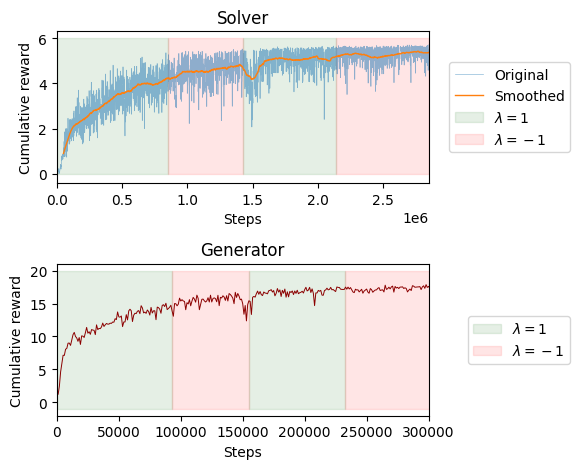

In [4]:
auxs = [0, .3, .5, .75, 1]
solver_cum_pd = df_solver.loc[df_solver["tag"]=="Environment/Cumulative Reward", ["step", "value"]]
ax1 = plt.subplot(2,1,1)

maxstep = 2.85e6
#  Generator
kwards = {'x':"step", 'y':"value", "kind":"line"}
solver_cum_pd.plot(**kwards, linewidth=.5, ax=ax1, alpha=.5, label="Original")
#  Smoothed version
solver_cum_pd.rolling(100).mean().plot(**kwards, linewidth=1, ax=ax1, label="Smoothed")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Cumulative reward")
ax1.set_xlim(0, maxstep)
ax1.set_title("Solver")
fill_args = {'alpha':0.1}
ymax = 6
# Regions
ax1.fill_betweenx([0,ymax],auxs[0]*maxstep,auxs[1]*maxstep, color='darkgreen', **fill_args,
                  label=r"$\lambda=1$")
ax1.fill_betweenx([0,ymax],auxs[1]*maxstep,auxs[2]*maxstep, color='red', **fill_args,
                  label=r"$\lambda=-1$")
ax1.fill_betweenx([0,ymax],auxs[2]*maxstep,auxs[3]*maxstep, color='darkgreen', **fill_args)
ax1.fill_betweenx([0,ymax],auxs[3]*maxstep,auxs[4]*maxstep, color='red', **fill_args)
ax1.legend(loc='center right',bbox_to_anchor=(1.4,.5))

# Solver
maxstep = 3.1e5
ymax=20
ymin=-1
# Solver
ax2 = plt.subplot(2,1,2)
gen_cum_pd = df_gen.loc[df_gen["tag"]=="Environment/Cumulative Reward", ["step", "value"]]
gen_cum_pd.plot(**kwards, ax=ax2, color='darkred', linewidth=.7, label="")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Cumulative reward")
ax2.set_xlim(0, 3e5)
# ax2.legend("", frameon=False)
ax2.set_title("Generator")
# Regions
ax2.fill_betweenx([ymin,ymax],auxs[0]*maxstep,auxs[1]*maxstep, color='darkgreen', **fill_args,
                  label=r"$\lambda=1$")
ax2.fill_betweenx([ymin,ymax],auxs[1]*maxstep,auxs[2]*maxstep, color='red', **fill_args,
                  label=r"$\lambda=-1$")
ax2.fill_betweenx([ymin,ymax],auxs[2]*maxstep,auxs[3]*maxstep, color='darkgreen', **fill_args)
ax2.fill_betweenx([ymin,ymax],auxs[3]*maxstep,auxs[4]*maxstep, color='red', **fill_args)
ax2.legend(loc='center right',bbox_to_anchor=(1.4,.5))
plt.tight_layout()
# plt.savefig("images/Cumm_reward_NoCurr42d.pdf")

# For test

In [5]:
from tbparse import SummaryReader

In [70]:
# Get the scores datas from tensorboard events
# Needs the tbparse module
def get_score(path, step_end=5e6):
    reader = SummaryReader(path)
    dfScore = reader.scalars
    # One big Dataframe for all the aux_input
    Score = dfScore.loc[dfScore["tag"]=='Score',['step', 'value']]
    Score.rename(columns = {'value':'Score'}, inplace=True)
    auxs = [1, 0.5, 0, -0.5, -1] # order of the aux input in the event file, changes every 1e6 steps
    
    Score["aux_input"] = 1
    Scores = dict() # A dictionary of Dataframe
    # Set the aux_input column for the corresponding steps
    for i, au in enumerate(auxs):
        # assign an aux_input for the big DataFrame
        Score.loc[Score["step"] > 1e6*i, "aux_input"] = au
        #Assign one dataFrame for each aux_input
        Scores[au] = Score.loc[Score["step"] > 1e6*i, ]
        
    Score = Score.loc[Score['step'] <= step_end,]
    return Score, Scores

In [49]:
ARL  = dict()
PCG  = dict()
PCG_Const = dict()
fixed = dict()

path_ARL = f"../../TrainerConfig/results/InferenceNoCurr_Curr42d_1/Solver/"
ARLs, ARL = get_score(path_ARL)

path_PCG = f"../../TrainerConfig/results/InferenceNoCurr_PCG_2/Solver/"
PCGs, PCG = get_score(path_PCG)

path_constPCG = f"../../TrainerConfig/results/InferenceNoCurrPCG_Const_1/Solver/"
PCG_Consts, PCG_Const = get_score(path_constPCG)
    
path_fixed = f"../../TrainerConfig/results/InferenceNoCurrFixed_2/Solver"
fixeds, fixed = get_score(path_fixed)

In [50]:
ARL[1]

,step,Score
50335,1000,0.074392
50336,2000,2.314286
50337,3000,3.000000
50338,4000,3.800000
50339,5000,4.869565
...,...,...
57705,7386000,8.000000
57706,7387000,8.700000
57707,7388000,8.600000
57708,7389000,6.333333


### Box plot of the scores for ARLPCG

Text(0.5, 1.0, '')

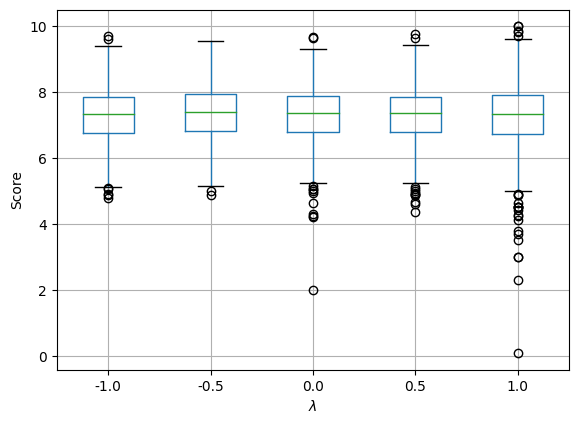

In [51]:
# ARLs = pd.concat([ARL[d] for d in ARL]) # Combine the DataFrames
grouped = ARLs.groupby('aux_input')
fig = plt.figure()
ax = fig.gca()
ax.grid()
# bp = grouped.boxplot(column=["Score"], subplots=False, ax=ax)
ARLs.loc[:,["Score", "aux_input"]].boxplot(by="aux_input", ax=ax)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel("Score")
plt.suptitle("")
plt.title("")

In [52]:
def boxplots(df, suptitle="", title="", ax=None, **kwargs):
    grouped = df.groupby('aux_input')
    
    # new figure
    if(ax == None):
        fig = plt.figure()
        ax = fig.gca()
        ax.grid()
    
    # box plot by aux_input
    df.loc[:,["Score", "aux_input"]].boxplot(by="aux_input", ax=ax, **kwargs)
    ax.set_xlabel(r"$\lambda$")
    ax.set_ylabel("Score")
#     ax.suptitle.set_text(suptitle)
    ax.title.set_text(title)

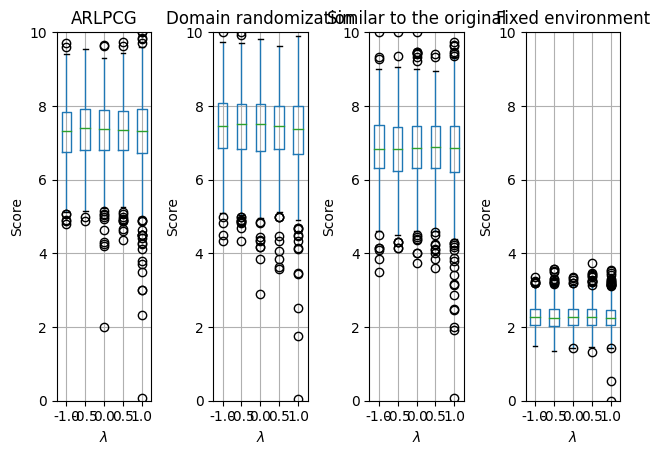

In [53]:
n = 4
fig = plt.figure()
axs = []
[axs.append(plt.subplot(1,n,i)) for i in range(1,n+1)]
# axs.append(plt.subplot(1,3,1))
# axs.append(plt.subplot(1,3,2))
# axs.append(plt.subplot(1,3,3))

for ax in axs:
    ax.set_ylim(0,10)

boxplots(ARLs, ax=axs[0], title="ARLPCG")
boxplots(PCGs, ax=axs[1], title="Domain randomization")
boxplots(PCG_Consts, ax=axs[2], title="Similar to the original")
boxplots(fixeds, ax=axs[3], title="Fixed environment")
plt.suptitle("")
plt.tight_layout()

In [54]:
PCG_Const[1].mean()

step     2.770456e+06
Score    6.851947e+00
dtype: float64

In [55]:
PCG[1].mean()

step     3.081937e+06
Score    7.396590e+00
dtype: float64

In [56]:
ARL[1].mean()

step     3.702967e+06
Score    7.312714e+00
dtype: float64

In [58]:
fixed[-1].mean()

step     6.500500e+06
Score    2.280048e+00
dtype: float64

In [71]:
def means(df_list, tag="Score"):
    value = []
    for d in df_list:
        value.append(d[tag].mean())
    return np.array(value)
    
def medians(df_list, tag="Score"):
    value = []
    for d in df_list:
        value.append(d[tag].median())
    return np.array(value)

def std(df_list, tag="Score"):
    value = []
    for d in df_list:
        value.append(d[tag].std())
    return np.array(value)

def ratio(df, aux, average_method = "mean"):
    if(average_method == "mean"):
        return df[aux]["Score"].mean() / 10
    elif(average_method == "median"):
        return df[aux]["Score"].median() / 10
    else:
        return df[aux]["Score"].mean() / 10
    
def ratioWithStd(df, aux, average_method = "mean"):
    std = df[aux]["Score"].std() / 10
    if(average_method == "mean"):
        av = df[aux]["Score"].mean() / 10
        return f"{av:.5f}$\pm${std:.3f}"
    elif(average_method == "median"):
        av = df[aux]["Score"].median() / 10
        return f"{av:.5f}$\pm${std:.3f}"

# Solving ratio without error

In [60]:
aux_list = [-1, -.5, 0, .5, 1]
models = ["ARLPCG", "PCG", "Const PCG", "Fixed"]
descr = dict()

# Create a table of the solving ratio
descr[models[0]] = {aux:ratio(ARL, aux) for aux in aux_list} #ARLPCG
descr[models[1]] = {aux:ratio(PCG, aux) for aux in aux_list} #PCG
descr[models[2]] = {aux: ratio(PCG_Const, aux) for aux in aux_list} #Const PCG
descr[models[3]] = {aux: ratio(fixed, aux) for aux in aux_list} # Fixed

In [61]:
pd.DataFrame(descr)

,ARLPCG,PCG,Const PCG,Fixed
-1.0,0.731198,0.741348,0.689860,0.228005
-0.5,0.732112,0.741569,0.686852,0.227855
0.0,0.732340,0.741081,0.687270,0.227938
0.5,0.732328,0.741140,0.686751,0.228048
1.0,0.731271,0.739659,0.685195,0.227987


In [63]:
descr1 = dict()

# Create a table of the solving ratio
descr1[models[0]] = {aux:ratio(ARL, aux, average_method='median') for aux in aux_list} #ARLPCG
descr1[models[1]] = {aux:ratio(PCG, aux, average_method='median') for aux in aux_list} #PCG
descr1[models[2]] = {aux: ratio(PCG_Const, aux,  average_method='median') for aux in aux_list} #Const PCG
descr1[models[3]] = {aux: ratio(fixed, aux,  average_method='median') for aux in aux_list} #Const PCG

pd.DataFrame(descr1)

,ARLPCG,PCG,Const PCG,Fixed
-1.0,0.735294,0.745000,0.688889,0.226316
-0.5,0.736364,0.746667,0.686667,0.225806
0.0,0.736364,0.747368,0.686364,0.226087
0.5,0.736364,0.747368,0.687500,0.226190
1.0,0.735714,0.745455,0.687500,0.226087


In [64]:
PCG[-0.5].median()

step     4.570000e+06
Score    7.466667e+00
dtype: float64

# Solving ratio with errors

In [74]:
aux_list = [-1, -.5, 0, .5, 1]
descrE = dict()

models = ["ARLPCG", "Domain randomization", "Original game", "Fixed environment"]

# Create a table of the solving ratio
descrE[models[0]] = {aux:ratioWithStd(ARL, aux) for aux in aux_list} #ARLPCG
descrE[models[1]] = {aux:ratioWithStd(PCG, aux) for aux in aux_list} #PCG
descrE[models[2]] = {aux: ratioWithStd(PCG_Const, aux) for aux in aux_list} #Const PCG
descrE[models[3]] = {aux: ratioWithStd(fixed, aux) for aux in aux_list} #Const PCG
descrE = pd.DataFrame(descrE)

# Rename the axis
descrE.rename_axis("$\lambda$", axis=1, inplace=True)

In [75]:
descrE

$\lambda$,ARLPCG,Domain randomization,Original game,Fixed environment
-1.0,0.73120$\pm$0.083,0.74135$\pm$0.089,0.68986$\pm$0.087,0.22800$\pm$0.032
-0.5,0.73211$\pm$0.083,0.74157$\pm$0.089,0.68685$\pm$0.087,0.22785$\pm$0.032
0.0,0.73234$\pm$0.083,0.74108$\pm$0.090,0.68727$\pm$0.087,0.22794$\pm$0.032
0.5,0.73233$\pm$0.083,0.74114$\pm$0.090,0.68675$\pm$0.087,0.22805$\pm$0.033
1.0,0.73127$\pm$0.085,0.73966$\pm$0.092,0.68519$\pm$0.090,0.22799$\pm$0.033


In [76]:
print(descrE.to_latex())

\begin{tabular}{lllll}
\toprule
$\lambda$ & ARLPCG & Domain randomization & Original game & Fixed environment \\
\midrule
-1.000000 & 0.73120$\pm$0.083 & 0.74135$\pm$0.089 & 0.68986$\pm$0.087 & 0.22800$\pm$0.032 \\
-0.500000 & 0.73211$\pm$0.083 & 0.74157$\pm$0.089 & 0.68685$\pm$0.087 & 0.22785$\pm$0.032 \\
0.000000 & 0.73234$\pm$0.083 & 0.74108$\pm$0.090 & 0.68727$\pm$0.087 & 0.22794$\pm$0.032 \\
0.500000 & 0.73233$\pm$0.083 & 0.74114$\pm$0.090 & 0.68675$\pm$0.087 & 0.22805$\pm$0.033 \\
1.000000 & 0.73127$\pm$0.085 & 0.73966$\pm$0.092 & 0.68519$\pm$0.090 & 0.22799$\pm$0.033 \\
\bottomrule
\end{tabular}



In [40]:
ARL[0.5].mean()

step     4.195500e+06
Score    7.323281e+00
dtype: float64